In [1]:
!conda install -c conda-forge statsmodels -y

Retrieving notices: ...working... done
Channels:
 - conda-forge
 - defaults
 - pytorch
 - anaconda
Platform: win-64
Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\user\anaconda3\envs\torch-book

  added / updated specs:
    - statsmodels


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    patsy-0.5.6                |     pyhd8ed1ab_0         183 KB  conda-forge
    statsmodels-0.14.2         |  py312h1a27103_0        11.0 MB  conda-forge
    ------------------------------------------------------------
                                           Total:        11.2 MB

The following NEW packages will be INSTALLED:

  patsy              conda-forge/noarch::patsy-0.5.6-pyhd8ed1ab_0 
  statsmodels        conda-forge/win-64::statsmodels-0.14.2-py312h1a27103_0 

The following packages will be SUPERSEDED by a higher-priority channel:

  certifi        

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose, STL

### 데이터 불러오기

In [3]:
df = pd.read_csv("data/jj.csv")
df["year"]=pd.DatetimeIndex(df["data"]).year
#datetime 형식의 data 열의 각 날짜에서 year만 추출해서 year 형성

In [12]:
df.columns

Index(['date', 'data', 'year'], dtype='object')

### 시계열 데이터 STL 분리

In [13]:
advanced_decomposition = STL (df.data, period=4).fit()
#'data': ['2024-01-01'.... ] 라고 치면 STL을 사용해서 시계열 데이터를 분해한다는 것
# STL로 분해하려면 pd.to_datetime 으로 변환하든 datetime 형태여야 함
# 계절성(Seasonality) = 4, 추세(Trend), 및 잔차(Residual) 로 분해

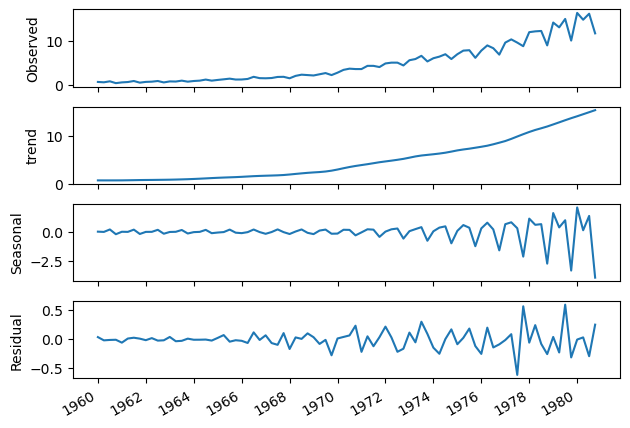

In [38]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True)
ax1.plot(advanced_decomposition.observed)
ax1.set_ylabel('Observed')
ax2.plot(advanced_decomposition.trend)
ax2.set_ylabel('trend')
ax3.plot(advanced_decomposition.seasonal)
ax3.set_ylabel('Seasonal')
ax4.plot(advanced_decomposition.resid)
ax4.set_ylabel('Residual')

plt.xticks(np.arange(0, 85, 8),
               [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980]
          )
plt.tight_layout()
fig.autofmt_xdate()

In [ ]:
# 해석: 상성이 있는 시계열 데이터라면 시즈널에서 같은 폭의 구름 형태가 나와야하거든

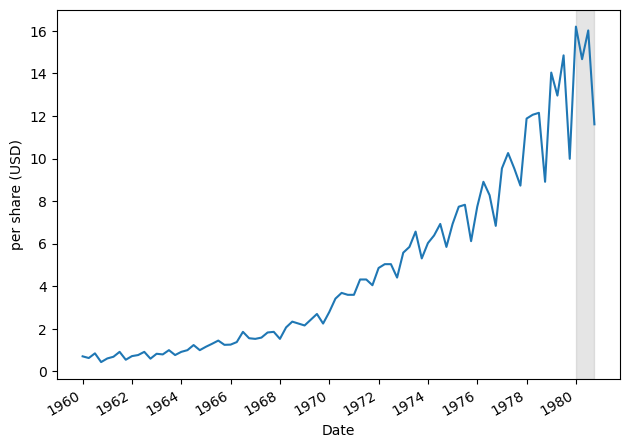

In [21]:
fig, ax = plt.subplots()

ax.plot(df["date"], df["data"]) #x축은 date열, y축은 data열 
ax.set_xlabel("Date")
ax.set_ylabel("per share (USD)")
ax.axvspan(80, 83, color="#808080", alpha=.2) #색깔 칠해서 시계열 데이터 보기 쉽게 하기. 저 구간 사이에 색을 주겠다 

plt.xticks(np.arange(0, 85, 8),
               [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980]
          )

plt.tight_layout()
fig.autofmt_xdate()

### 내가 원하는 회색칸의 값 예측하기

In [29]:
#마지막 4개를 제외한 모든 데이터를 행들을 train으로, 
#마지막 4개를 test로.
train = df[:-4]
test = df[-4:]

In [30]:
historical_mean = np.mean(train["data"])
historical_mean

4.308499987499999

In [31]:
test.loc[:, "pred_mean"] = historical_mean
# 저 열이 존재하지 않으면 historical_mean의 값으로 쫙쫙 그냥 업데이트 하는거임 ^^ 
#historical_mean을 사용하여 test 데이터프레임에 "pred_mean" 열을 추가

C:\Users\user\AppData\Local\Temp\ipykernel_21228\1888505569.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, "pred_mean"] = historical_mean


In [32]:
#실제 값과 예측 값 사이 오차 계산
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true-y_pred) / y_true )) * 100

In [33]:
historical_mean = mape(test["data"], test["pred_mean"])
historical_mean

70.00752579965119

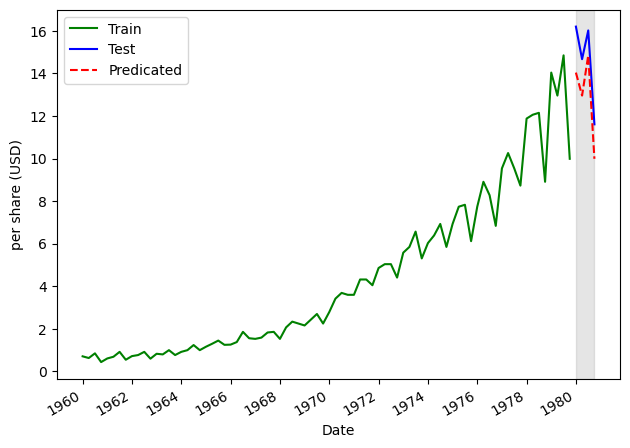

In [51]:
fig, ax = plt.subplots()

ax.plot(train["date"], train["data"], "g-", label="Train") #x축은 date열, y축은 data열 
ax.plot(test["date"], test["data"], "b-", label="Test")
ax.plot(test["date"], test["pred_last_season"], "r--", label="Predicated")

ax.set_xlabel("Date")
ax.set_ylabel("per share (USD)")
ax.axvspan(80, 83, color="#808080", alpha=.2) #색깔 칠해서 시계열 데이터 보기 쉽게 하기. 저 구간 사이에 색을 주겠다 
ax.legend(loc=2)

plt.xticks(np.arange(0, 85, 8),
               [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980]
          )

plt.tight_layout()
fig.autofmt_xdate()

## MA

In [39]:
last_year_mean = np.mean(train["data"][-4:])
last_year_mean

12.96

In [52]:
#모든 행에 대해 동일한 평균값을 사용하여 예측합니다.

test.loc[:, "pred_last_year_mean"] = last_year_mean
mape_last_year_mean = mape(test["data"], test["pred_last_year_mean"])
mape_last_year_mean

15.5963680725103

In [53]:
#최근 데이터 예측 (pred_last_season): 최근 4개의 값을 사용하여 예측값을 설정

test.loc[:, "pred_last_season"] = train["data"][-4:].values
mape_last_year_mean = mape(test["data"], test["pred_last_season"])
mape_last_year_mean

11.561658552433654

## ARIMA 오류로 인해 SARIMAX 교체 (교재 예제)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

from datetime import datetime

In [2]:
series = pd.read_csv("data/sales.csv", index_col=0, parse_dates=[0], date_format="%Y-%m")
series.head()

,Sales
Month,
1-01,266.0
1-02,145.9
1-03,183.1
1-04,119.3
1-05,180.3


In [3]:
X = series.values
X = np.nan_to_num(X)
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = []

In [4]:
for t in range(len(test)):
    model = SARIMAX(history, order=(5,1,0))
    model_fit = model.fit(disp=False)
    output = model_fit.predict()
    yhat = output.mean()
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print(f"{yhat}, {obs}")

202.9199826098349, [346.3]
208.95480883675782, [329.7]
212.66722114606327, [445.4]
220.25891030746968, [325.9]
224.26051185452113, [449.3]
230.42828600966945, [411.3]
236.29276401578616, [417.4]
242.5377814458718, [545.5]
249.03615982957018, [477.6]
255.97566728891331, [687.]
268.8276970183351, [435.3]
273.5093899061235, [587.3]
282.2939063036349, [676.9]


In [5]:
error = mean_squared_error(test, predictions)
print(error)

63716.92691937807


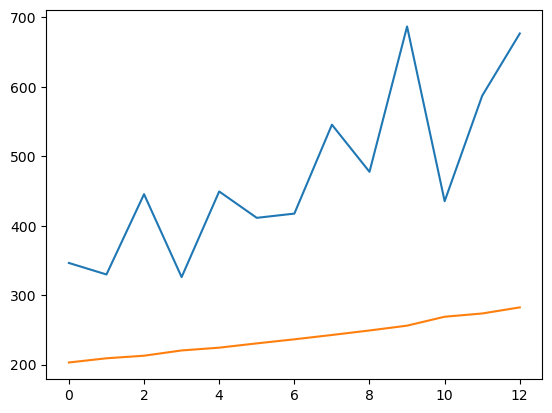

In [6]:
plt.plot(test)
plt.plot(predictions)